# Rescheduling mit Tardiness (Summe)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import tardiness_scheduling as cp_tard_schedule
from src.models.cp import tardiness_rescheduling as cp_tard_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 5 # 5 min

In [3]:
basic_data_path = get_path("data", "basic")
day_count = 1

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)

df_job_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_job_times


Schedule-Informationen:
  Makespan: 2400


,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,848.0
1,1,1,130,1162.0
2,2,2,151,1300.0
3,3,3,226,1551.0
4,4,4,386,1181.0
5,5,5,464,1467.0
6,6,6,480,1322.0
7,7,7,506,1596.0
8,8,8,526,1734.0
9,9,9,535,1627.0


In [4]:
df_job_times["Arrival"] = np.floor(df_job_times["Arrival"]).astype(int)
df_job_times["Deadline"] = np.ceil(df_job_times["Deadline"]).astype(int)
df_job_times

,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,848
1,1,1,130,1162
2,2,2,151,1300
3,3,3,226,1551
4,4,4,386,1181
5,5,5,464,1467
6,6,6,480,1322
7,7,7,506,1596
8,8,8,526,1734
9,9,9,535,1627


## I) Complete Scheduling

In [5]:
# Scheduling
df_schedule = cp_tard_schedule.solve_jssp_sum(df_jssp, df_job_times, msg = False, timeLimit=max_time)
df_schedule


Solver-Status         : OPTIMAL
Summe Tardiness        : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 0.03 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness
0,0,0,0,49,848,M00,49,29,78,-770,0
1,0,0,1,49,848,M01,78,78,156,-692,0
2,1,1,0,130,1162,M00,130,43,173,-989,0
3,0,0,2,49,848,M02,156,9,165,-683,0
4,2,2,0,151,1300,M01,156,91,247,-1053,0
...,...,...,...,...,...,...,...,...,...,...,...
195,18,5,5,1397,2400,M09,2128,72,2200,-200,0
196,18,5,6,1397,2400,M00,2200,47,2247,-153,0
197,18,5,7,1397,2400,M06,2247,65,2312,-88,0
198,18,5,8,1397,2400,M04,2312,6,2318,-82,0


In [6]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


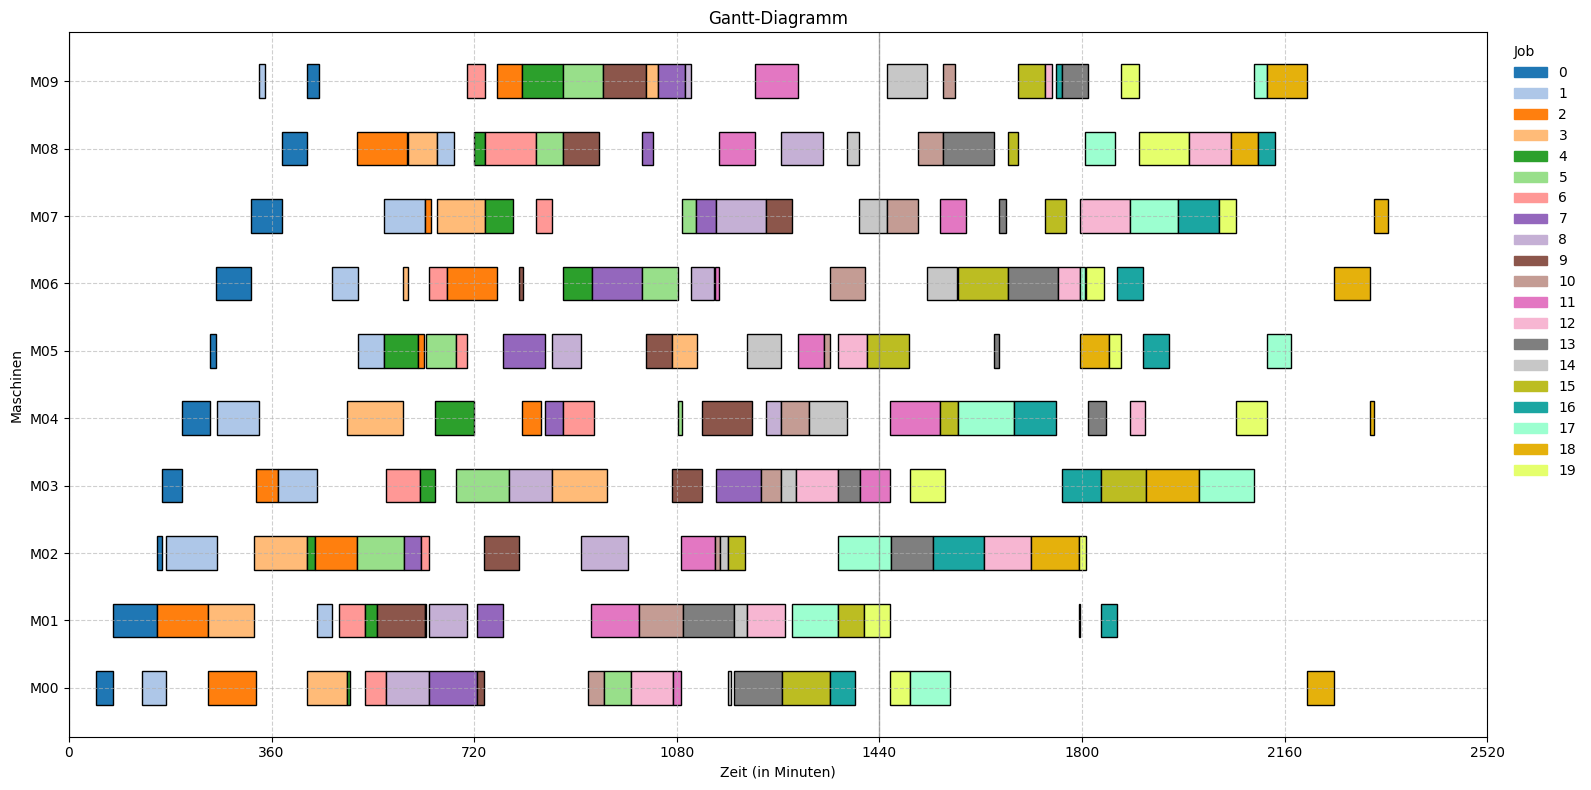

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## II) Erster Tag (Tag 0)

### a) Simulation

In [8]:
day_length = 1440

In [9]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [10]:
simulation = ProductionDaySimulation(df_schedule, vc=0.35)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[00:49:00] Job 0 started on M00
[01:22:10] Job 0 finished on M00 (after 33 minutes 11 seconds)
[01:22:10] Job 0 started on M01
[02:10:00] Job 1 started on M00
[02:58:35] Job 1 finished on M00 (after 48 minutes 36 seconds)
[02:58:35] Job 1 started on M02
[03:57:24] Job 0 finished on M01 (after 155 minutes 13 seconds)
[03:57:24] Job 2 started on M01
[05:03:16] Job 1 finished on M02 (after 124 minutes 40 seconds)
[05:03:16] Job 0 started on M02
[05:03:16] Job 1 started on M04
[05:09:28] Job 0 finished on M02 (after 06 minutes 12 seconds)
[05:09:28] Job 0 started on M03
[06:10:29] Job 1 finished on M04 (after 67 minutes 13 seconds)
[06:10:29] Job 1 started on M09
[06:19:37] Job 2 finished on M01 (after 142 minutes 13 seconds)
[06:19:37] Job 3 started on M01
[06:19:37] Job 2 started on M00
[06:23:48] Job 1 finished on M09 (after 13 minutes 19 seconds)
[06:39:43] Job 0 finished on M03 (after 90 minutes 15 seconds)
[06:39:43] Job 1 started on M03
[06:39:43] Job 0 started on M04
[07:03:00] Job

In [11]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness
0,7,7,9,506,1596,M03,1150,79,1229,-367,0
1,14,4,3,1127,1922,M05,1204,61,1265,-657,0
2,8,8,8,526,1734,M04,1239,26,1265,-469,0
3,8,8,9,526,1734,M08,1265,74,1339,-395,0
4,14,4,4,1127,1922,M03,1265,26,1291,-631,0
...,...,...,...,...,...,...,...,...,...,...,...
71,18,5,5,1397,2400,M09,2128,72,2200,-200,0
72,18,5,6,1397,2400,M00,2200,47,2247,-153,0
73,18,5,7,1397,2400,M06,2247,65,2312,-88,0
74,18,5,8,1397,2400,M04,2312,6,2318,-82,0


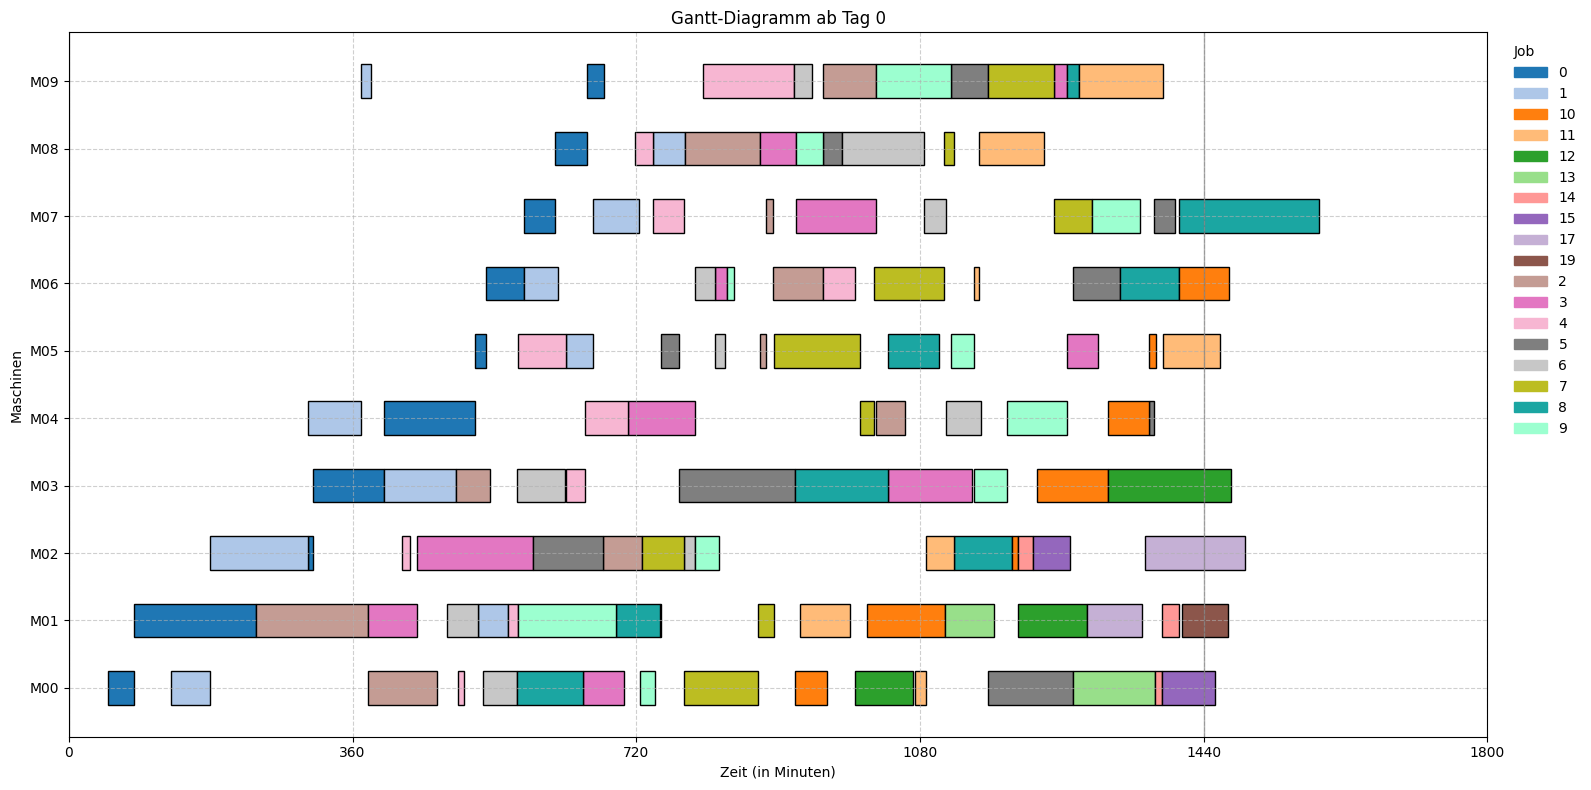

In [12]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [13]:
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness
0,7,7,9,506,1596,M03,1150,79,1229,-367,0
1,14,4,3,1127,1922,M05,1204,61,1265,-657,0
2,8,8,8,526,1734,M04,1239,26,1265,-469,0
3,8,8,9,526,1734,M08,1265,74,1339,-395,0
4,14,4,4,1127,1922,M03,1265,26,1291,-631,0
...,...,...,...,...,...,...,...,...,...,...,...
71,18,5,5,1397,2400,M09,2128,72,2200,-200,0
72,18,5,6,1397,2400,M00,2200,47,2247,-153,0
73,18,5,7,1397,2400,M06,2247,65,2312,-88,0
74,18,5,8,1397,2400,M04,2312,6,2318,-82,0


In [14]:
df_job_times_undone = process_filter.update_times_after_operation_changes(df_job_times, df_plan_undone)
df_job_times_undone

,Job,Production_Plan_ID,Arrival,Deadline
0,7,7,506,1596
1,8,8,526,1734
2,10,0,922,1721
3,11,9,928,2020
4,12,8,950,2158
5,13,2,1001,2150
6,14,4,1127,1922
7,15,7,1142,2232
8,16,1,1254,2286
9,17,3,1285,2610


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [15]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
86,8,8,7,M07,526,1408.62,177.68,1586.30
103,10,0,6,M06,922,1408.62,63.49,1472.11
110,11,9,6,M05,928,1388.29,72.83,1461.12
113,12,8,2,M03,950,1319.15,155.42,1474.57
120,15,7,1,M00,1142,1387.64,67.34,1454.98
122,17,3,1,M02,1285,1366.00,126.37,1492.37
123,19,6,0,M01,1398,1412.00,59.42,1471.42


In [16]:
df_reschedule = cp_tard_reschedule.solve_jssp_sum_with_fixed_ops(df_plan_undone, df_job_times_undone, 
                                                                 df_execution_important, reschedule_start = 1440, 
                                                                 msg=False, timeLimit=max_time, gapRel= 0)
df_reschedule


Solver-Status         : OPTIMAL
Summe Tardiness       : 35.0
Best Objective Bound  : 35.0
Laufzeit              : 0.09 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness
0,16,1,0,1254,2286,M00,1455,43,1498,-788,0
1,14,4,3,1127,1922,M05,1462,61,1523,-399,0
2,15,7,2,1142,2232,M01,1472,46,1518,-714,0
3,7,7,9,506,1596,M03,1475,79,1554,-42,0
4,18,5,0,1397,2400,M02,1493,84,1577,-823,0
...,...,...,...,...,...,...,...,...,...,...,...
71,17,3,6,1285,2610,M07,2219,85,2304,-306,0
72,17,3,7,1285,2610,M03,2304,98,2402,-208,0
73,18,5,9,1397,2400,M07,2304,25,2329,-71,0
74,17,3,8,1285,2610,M09,2402,22,2424,-186,0


In [17]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            10
0 - 60        2
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


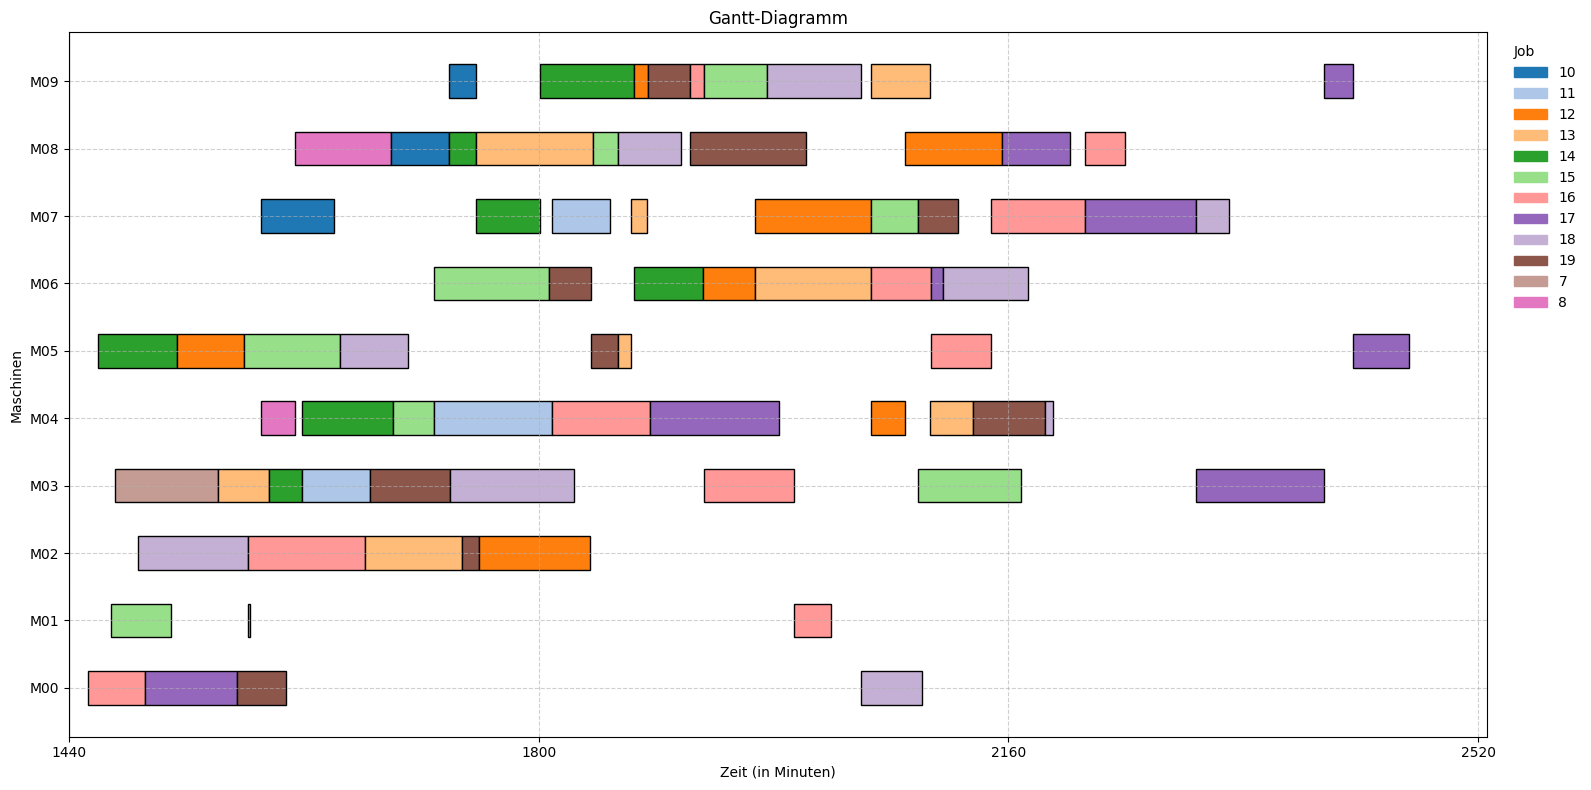

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [18]:
show.plot_gantt(df_reschedule, perspective="Machine")
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

## Simulation + neuer Schedule 

In [19]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End,Deadline,Lateness,Tardiness
0,0,0,0,M00,49,49.00,33.18,82.18,NaN,NaN,NaN
1,0,0,1,M01,49,82.18,155.22,237.40,NaN,NaN,NaN
2,0,0,2,M02,49,303.27,6.20,309.47,NaN,NaN,NaN
3,0,0,3,M03,49,309.47,90.25,399.72,NaN,NaN,NaN
4,0,0,4,M04,49,399.72,115.45,515.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
195,17,3,6,M07,1285,2219.00,85.00,2304.00,2610.0,-306.0,0.0
196,17,3,7,M03,1285,2304.00,98.00,2402.00,2610.0,-208.0,0.0
197,18,5,9,M07,1397,2304.00,25.00,2329.00,2400.0,-71.0,0.0
198,17,3,8,M09,1285,2402.00,22.00,2424.00,2610.0,-186.0,0.0


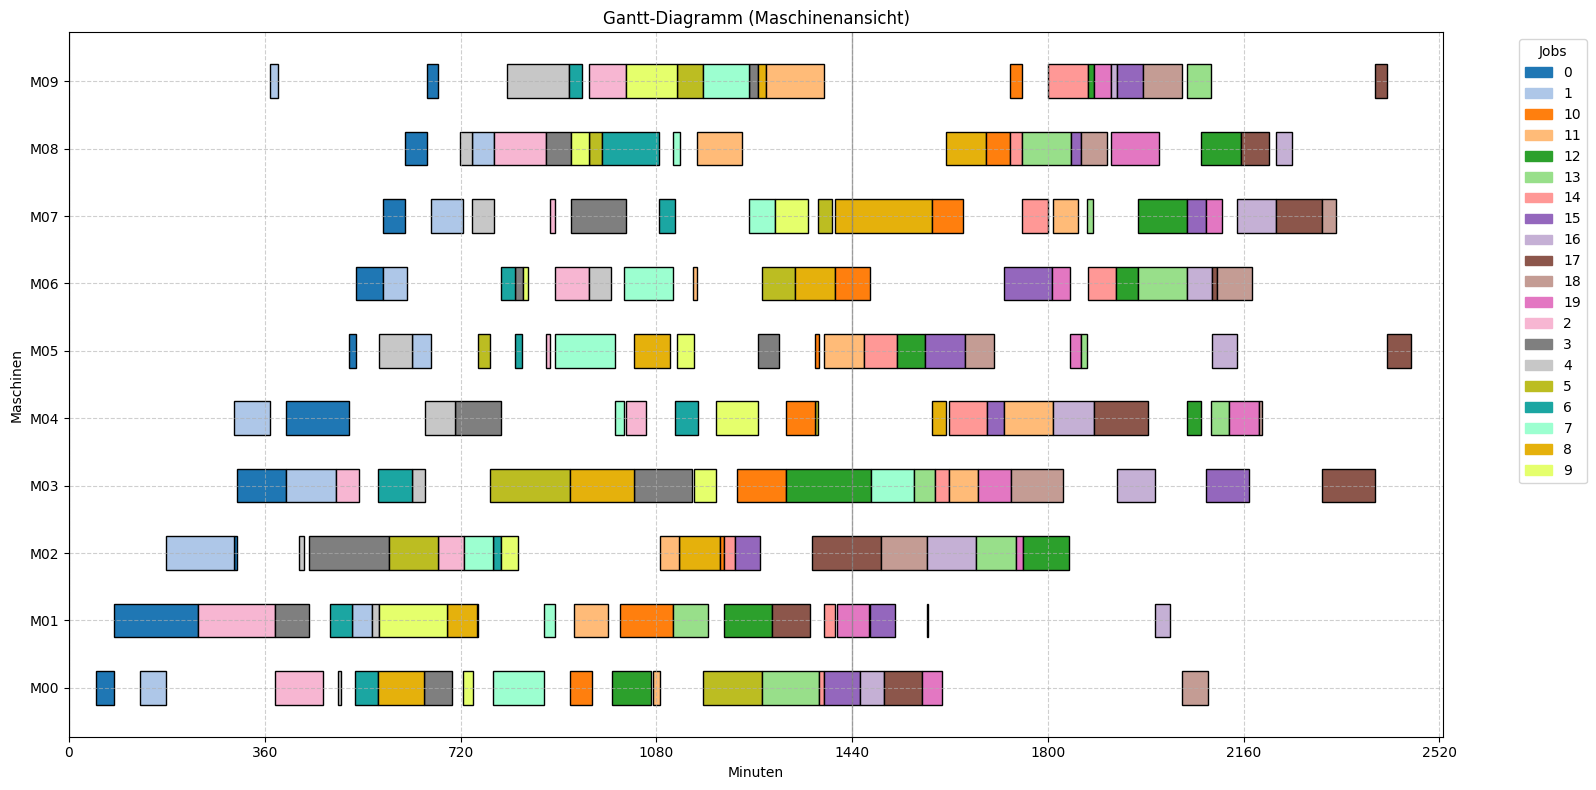

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [20]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)